# Introduction to Recommender Systems: Collaborative Filtering

[Reference](https://www.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/)

## Downloading The Data: MovieLens dataset

In [10]:
! curl -O http://files.grouplens.org/datasets/movielens/ml-100k.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 4808k    0 20161    0     0  12808      0  0:06:24  0:00:01  0:06:23 12808
 24 4808k   24 1163k    0     0   455k      0  0:00:10  0:00:02  0:00:08  455k
100 4808k  100 4808k    0     0  1644k      0  0:00:02  0:00:02 --:--:-- 1643k


In [13]:
with zipfile.ZipFile('ml-100k.zip', 'r') as zip_ref:
    zip_ref.extractall('')

## Loading The Data

In [172]:
names = ['user_id', 'item_id', 'rating', 'timestamp']

In [173]:
df = pd.read_csv("ml-100k/u.data", sep = '\t', names = names)
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


checking the unique values of items and users

In [174]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]

print(f'Number of:\n -Users: {n_users}\n -Items: {n_items}')

Number of:
 -Users: 943
 -Items: 1682


## Feature Engineering

Creating the user-item matrix

In [175]:
M = np.zeros((n_users, n_items))

we subtract 1 of the user and item id's bacause they start at 1, so to is needed to mach with the numpy array index

In [176]:
for row in df.itertuples(index = False):
    
    M[row[0]-1, row[1]-1] = row[2]

In [177]:
M

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [178]:
sparsity = len(M.nonzero()[0])
sparsity /= (M.shape[0] * M.shape[1])

sparsity *= 100

print(f'Sparsity: {sparsity:.2f}%')

Sparsity: 6.30%


This means that $\sim$ 10% of your data is not an ampty value.

## Creating The Train And Test Datasets

In [179]:
train, test = train_test_split(M)

## **Collaborative Filltering**

In [180]:
%timeit similarity(train, kind='user')

1.99 s ± 24.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [181]:
user_similarity = similarity(train)
item_similarity = similarity(train, kind = 'item')

In [182]:
print(user_similarity[:4, :4])

[[1.         0.15254642 0.04837414 0.06559807]
 [0.15254642 1.         0.11059132 0.17812119]
 [0.04837414 0.11059132 1.         0.34415072]
 [0.06559807 0.17812119 0.34415072 1.        ]]


In [183]:
print(item_similarity[:4, :4])

[[1.         0.40238218 0.33024479 0.45493792]
 [0.40238218 1.         0.27306918 0.50257077]
 [0.33024479 0.27306918 1.         0.32486639]
 [0.45493792 0.50257077 0.32486639 1.        ]]


## Prediction

In [184]:
pred_users = predict(train, user_similarity)

In [185]:
pred_items = predict(train, item_similarity, kind = 'item')

## Validation

In [186]:
print(f'User-Based MSE: {get_mean_squared_error(pred_users, test):.2f}')
print(f'Item-Based MSE: {get_mean_squared_error(pred_items, test):.2f}')

User-Based MSE: 6.83
Item-Based MSE: 8.08


## **Top-K Collaborative Filtering**

In [187]:
pred_user = predict_ktop(train, user_similarity)

<ipython-input-167-dc9439dfc211>:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users])
<ipython-input-167-dc9439dfc211>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))


In [188]:
pred_item = predict_ktop(train, item_similarity, kind = 'item')

<ipython-input-167-dc9439dfc211>:24: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = similarity[j, :][top_k_users].dot(ratings[i, :][top_k_users].T)
<ipython-input-167-dc9439dfc211>:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_users]))


In [189]:
print(f'Top-K User-Based CF MSE: {get_mean_squared_error(pred_user, test):.2f}')
print(f'Top-K Item-Based CF MSE: {get_mean_squared_error(pred_item, test):.2f}')

Top-K User-Based CF MSE: 3.60
Top-K Item-Based CF MSE: 2.39


## Tunning Parameter

In [190]:
k_tunning = [5, 15, 30, 50, 100, 200]

In [191]:
user_train_mse = []
user_test_mse = []

item_train_mse = []
item_test_mse = []

In [192]:
for kt in k_tunning:

    user_pred = predict_ktop(train, user_similarity, k = kt)
    item_pred = predict_ktop(train, item_similarity, kind = 'item', k = kt)
    
    user_train_mse += [get_mean_squared_error(user_pred, train)]
    item_train_mse += [get_mean_squared_error(item_pred, train)]
    
    user_test_mse += [get_mean_squared_error(user_pred, test)]
    item_test_mse += [get_mean_squared_error(item_pred, test)]

<ipython-input-167-dc9439dfc211>:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users])
<ipython-input-167-dc9439dfc211>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
<ipython-input-167-dc9439dfc211>:24: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(se

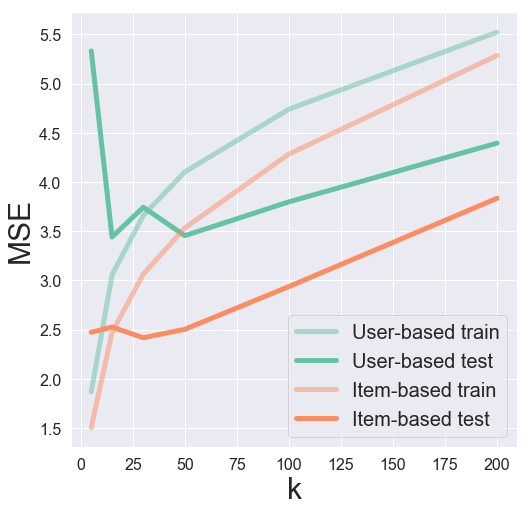

In [193]:
sns.set()

pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_tunning, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_tunning, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_tunning, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_tunning, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

## **Bais-Subtracted Collaborative Filtering**

In [199]:
nobias_user = predict_nobias(train, user_similarity)
nobias_item = predict_nobias(train, item_similarity, kind = 'item')

In [200]:
print(f'Bias-subtracted User-based CF MSE: {get_mean_squared_error(nobias_user, test):.2f}')
print(f'Bias-subtracted Item-based CF MSE: {get_mean_squared_error(nobias_item, test):.2f}')

Bias-subtracted User-based CF MSE: 5.68
Bias-subtracted Item-based CF MSE: 5.49


## **Top-K With Bias-subtracted**

In [203]:
ktop_nobias_user = predict_ktop_nobias(train, user_similarity)
ktop_nobias_item = predict_ktop_nobias(train, item_similarity, kind = 'item')

<ipython-input-202-3c6cc31c829a>:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users])
<ipython-input-202-3c6cc31c829a>:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
<ipython-input-202-3c6cc31c829a>:34: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(se

In [204]:
print(f'Top-K Bias-subtracted User-based CF MSE: {get_mean_squared_error(ktop_nobias_user, test):.2f}')
print(f'Top-K Bias-subtracted Item-based CF MSE: {get_mean_squared_error(ktop_nobias_item, test):.2f}')

Top-K Bias-subtracted User-based CF MSE: 3.69
Top-K Bias-subtracted Item-based CF MSE: 2.66


In [205]:
k_array = [5, 15, 30, 50, 100, 200]

user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

for k in k_array:
    user_pred = predict_ktop_nobias(train, user_similarity, kind='user', k=k)
    item_pred = predict_ktop_nobias(train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mean_squared_error(user_pred, train)]
    user_test_mse += [get_mean_squared_error(user_pred, test)]
    
    item_train_mse += [get_mean_squared_error(item_pred, train)]
    item_test_mse += [get_mean_squared_error(item_pred, test)]  

<ipython-input-202-3c6cc31c829a>:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users])
<ipython-input-202-3c6cc31c829a>:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
<ipython-input-202-3c6cc31c829a>:34: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(se

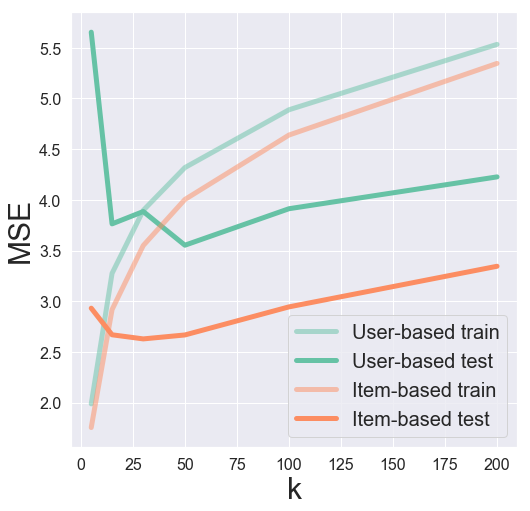

In [206]:
pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

## **Functions**

In [202]:
def predict_ktop_nobias(ratings, similarity, kind = 'user', k = 40):
    
    pred = np.zeros(ratings.shape)
    
    if kind == 'user':
        
        user_bias = ratings.mean(axis = 1)
        
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        
        for i in np.arange(ratings.shape[0]):
            
            top_k_users = [np.argsort(similarity[:, i])[:-k-1:-1]]
                        
            for j in np.arange(ratings.shape[1]):
                
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
        
        pred += user_bias[:, np.newaxis]
    
    if kind == 'item':
        
        item_bias = ratings.mean(axis = 0)
        
        ratings = (ratings - item_bias[np.newaxis, :]).copy()
        
        for j in np.arange(ratings.shape[1]):
            
            top_k_users = [np.argsort(similarity[:, j])[:-k-1:-1]]
            
            for i in np.arange(ratings.shape[0]):
                
                pred[i, j] = similarity[j, :][top_k_users].dot(ratings[i, :][top_k_users].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_users]))
    
        pred += item_bias[np.newaxis, :]
        
    return pred

In [198]:
def predict_nobias(ratings, similarity, kind = 'user'):
    
    if kind == 'user':
        
        user_bias = ratings.mean(axis = 1)
        
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        
        pred = similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis = 1)]).T
        pred += user_bias[:, np.newaxis]
        
    if kind == 'item':
        
        item_bias = ratings.mean(axis = 0)
        
        ratings = (ratings - item_bias[np.newaxis, :]).copy()
        
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis = 1)])
        pred += item_bias[np.newaxis, :]
    
    return pred

In [167]:
def predict_ktop(ratings, similarity, kind = 'user', k = 40):
    
    pred = np.zeros(ratings.shape)
    
    if kind == 'user':
        
        for i in np.arange(ratings.shape[0]):
            
            top_k_users = [np.argsort(similarity[:, i])[:-k-1:-1]]
                        
            for j in np.arange(ratings.shape[1]):
                
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    
    if kind == 'item':
        
        for j in np.arange(ratings.shape[1]):
            
            top_k_users = [np.argsort(similarity[:, j])[:-k-1:-1]]
            
            for i in np.arange(ratings.shape[0]):
                
                pred[i, j] = similarity[j, :][top_k_users].dot(ratings[i, :][top_k_users].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_users]))
    
    return pred

In [168]:
def get_mean_squared_error(pred, actual):
    
    # Ignoring the nonzero terms.
    
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    
    return mean_squared_error(pred, actual)
    

In [169]:
def predict(ratings, similarity, kind = 'user'):
    
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis = 1)]).T
    
    if kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis = 1)])

In [170]:
def similarity(ratings, kind = 'user', precision = 1e-9):
    
    if kind == 'user':
        
        dot = ratings.dot(ratings.T) + precision
    
    elif kind == 'item':
        
        dot = ratings.T.dot(ratings) + precision
    
    norms = np.array([np.sqrt(np.diagonal(dot))])
    
    return (dot / norms / norms.T)

In [171]:
def train_test_split(M):
    
    train = M.copy()
    test = np.zeros((M.shape[0], M.shape[1]))
    
    for user in np.arange(M.shape[0]):
        
        test_ratings = np.random.choice( M[user, :].nonzero()[0], size = 10, replace = False)
        
        train[user, test_ratings] = 0
        test[user, test_ratings] = M[user, test_ratings]
        
        assert(np.all((train * test) == 0))
        
        return train, test

## Imports 

In [161]:
import numpy as np

In [162]:
import pandas as pd

In [163]:
import zipfile

In [164]:
from sklearn.metrics import mean_squared_error

In [165]:
import matplotlib.pyplot as plt

In [166]:
import seaborn as sns